# CAB420, Sequenes, Example 2: Sequence to Sequence Prediction
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
Often when dealing with sequences, often we wish to predict a sequence as our output. We can easily use neural networks to do that as well.

## Too Long; Didn't Read:
* Sometimes, the output for a sequence is another sequence. Language translation is a classic example of this where a sentence in one language is mapped to a sentence in another.
* To make such predictions, we simply ask our recurrent network to generate a sequential output.
* We may also wish to use a bi-directional recurrent network, which will parse the input forwards and backwards, allowing the network to better understand the data and dependancies within it.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas
import numpy
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, TimeDistributed

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.utils import plot_model

import scipy.io

## The Data
Our data comes from the Edinburgh Informatics Forum pedestrian dataset: http://homepages.inf.ed.ac.uk/rbf/FORUMTRACKING/.
This contains trajectories for a bunch of people as they move through a buliding foyer. Our task will be to predict the next part of the trajectory. Out input will be:
* The first 50 observations of a trajectory

From which we'll try to predict
* The next 50 observations of a trajectory

Essentially, this is a sequence to sequence regression task.
We have a bunch of files for different days that we'll load up and break down.

In [2]:
def parsedata(data, in_length, out_length, window_step, subsample):

    in_traj = []
    out_traj = []

    for i in range(len(data)):
        
        traj = data[i][:, 0:2].astype('float32')
        traj[:, 0] = traj[:, 0] / 640
        traj[:, 1] = traj[:, 1] / 480
               
        startpos = 1
        endpos = in_length + out_length;
        
        while (endpos < len(traj)):
            
            traj_in = traj[startpos:startpos+in_length:subsample, :]
            traj_out = traj[startpos+in_length:endpos:subsample, :]
                        
            vel_in = numpy.sum(numpy.abs(traj_in[0, :] - traj_in[-1, :])) / len(traj_in)
            vel_out = numpy.sum(numpy.abs(traj_out[0, :] - traj_out[-1, :])) / len(traj_out)
                        
            if ((vel_in > 0.005) & (vel_out > 0.005)):
                in_traj.append(traj_in)
                out_traj.append(traj_out)
            
            startpos += window_step
            endpos += window_step
    
    return in_traj, out_traj

In [3]:
data = scipy.io.loadmat('../data/EIF/aug24.mat')
aug24_in, aug24_out = parsedata(data['aug24'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/aug25.mat')
aug25_in, aug25_out = parsedata(data['aug25'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/aug26.mat')
aug26_in, aug26_out = parsedata(data['aug26'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/aug27.mat')
aug27_in, aug27_out = parsedata(data['aug27'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/aug28.mat')
aug28_in, aug28_out = parsedata(data['aug28'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/aug29.mat')
aug29_in, aug29_out = parsedata(data['aug29'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/sep01.mat')
sep01_in, sep01_out = parsedata(data['sep01'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/sep02.mat')
sep02_in, sep02_out = parsedata(data['sep02'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/sep04.mat')
sep04_in, sep04_out = parsedata(data['sep04'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/sep05.mat')
sep05_in, sep05_out = parsedata(data['sep05'][0], 50, 50, 10, 2)
data = scipy.io.loadmat('../data/EIF/sep06.mat')
sep06_in, sep06_out = parsedata(data['sep06'][0], 50, 50, 10, 2)

We'll use the first 9 files for training, and the last 2 for testing.

In [4]:
train_X = aug24_in + aug25_in + aug26_in + aug27_in + aug28_in + aug29_in + sep01_in + sep02_in + sep04_in
train_Y = aug24_out + aug25_out + aug26_out + aug27_out + aug28_out + aug29_out + sep01_out + sep02_out + sep04_out
test_X = sep05_in + sep06_in
test_Y = sep05_out + sep06_out

print(len(train_X))
print(len(train_Y))
print(len(test_X))
print(len(test_Y))

8126
8126
325
325


In [5]:
train_X = numpy.array(train_X)
train_Y = numpy.array(train_Y)
test_X = numpy.array(test_X)
test_Y = numpy.array(test_Y)

print(numpy.shape(train_X))
print(numpy.shape(train_Y))
print(numpy.shape(test_X))
print(numpy.shape(test_Y))

(8126, 25, 2)
(8126, 25, 2)
(325, 25, 2)
(325, 25, 2)


We can visualise some of the days too to have a look at what we're dealing with.

Text(0.5, 1.0, 'September 5')

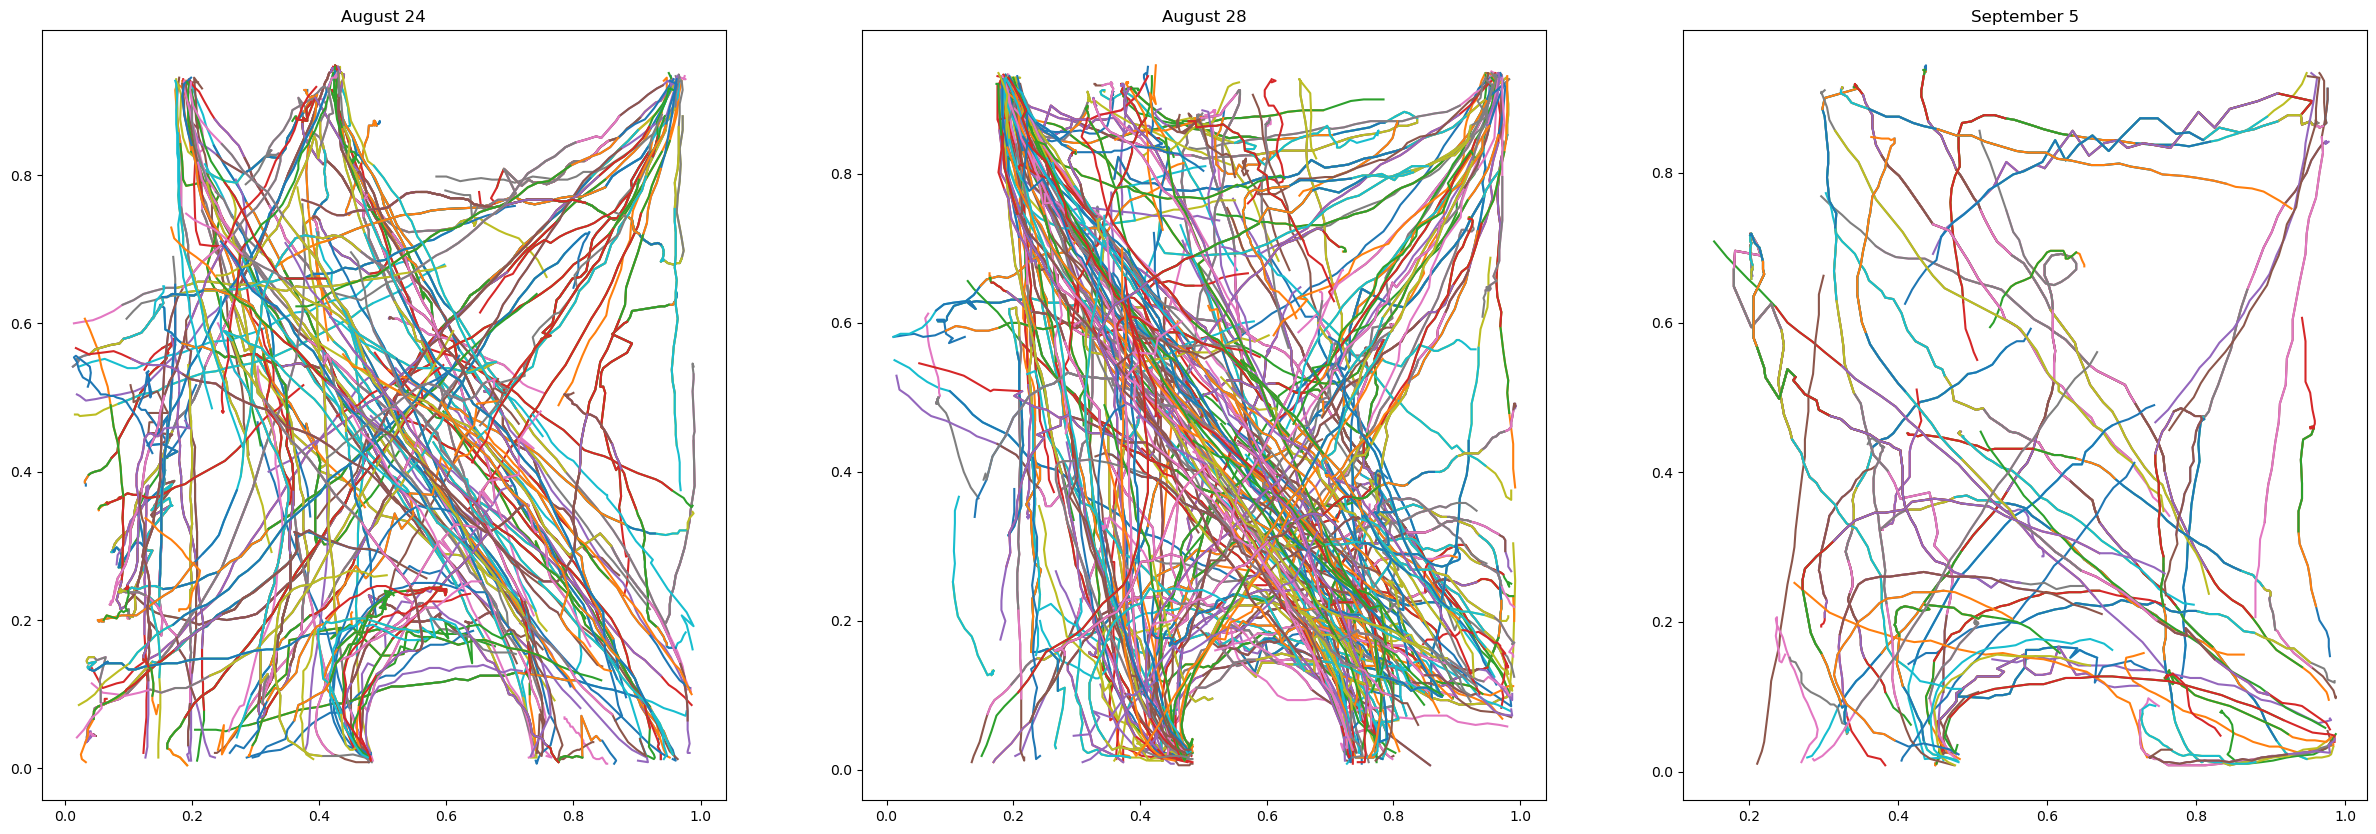

In [6]:
fig = plt.figure(figsize=[30, 10])
ax = fig.add_subplot(1, 3, 1)
for i in aug24_in:
    ax.plot(i[:,0], i[:,1])
ax.set_title('August 24')
    
ax = fig.add_subplot(1, 3, 2)
for i in aug28_in:
    ax.plot(i[:,0], i[:,1])
ax.set_title('August 28')

ax = fig.add_subplot(1, 3, 3)
for i in sep05_in:
    ax.plot(i[:,0], i[:,1])    
ax.set_title('September 5')    

## Approach 1: Sequence to Sequence Model
Let's start with a simple model. This can be seen as an encoder-decoder where:
* Our encoder is an LSTM that produces a sequence output
* Our decoder is an LSTM that produces a sequence output

We'll then have a sigmoid activation for the [0..1] range that we have in our output, and use a MSE loss

In [7]:
hidden_dim = 300
# input
pi_input = Input(shape = (25, 2), name = 'pedestrian_of_interest')

# LSTM encoder, encodes the input
encoder_outputs = LSTM(hidden_dim, return_sequences=True, return_state=False, 
                       unroll=False, name='pi_encoder1')(pi_input)
# LSTM decoder, decodes to something hopefully close to our output
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=False, 
                    unroll=False, name='pi_decoder1')(encoder_outputs)

# final layer to go from decoded embeddings to predictions
# Note the use of the TimeDistributed wrapper here. This will apply the layer inside the 
# wrapper, i.e. a Dense(2), to each timestep. So for each of the 25 timesteps, we'll 
# apply the same Dense(2) layer to go from 300 -> 2 dimensions, i.e. map from a 300
# dimension embedding down to the (x,y) coords
output = TimeDistributed(Dense(2), name='output_trajectory')(decoder_lstm)

model = Model(pi_input, output)

model.compile('adam', 'mse', metrics=['accuracy'], jit_compile=False)
model.summary()
# NOTE: at present, using tf 2.15.0 and keras 3.0.2, plot_model doesn't work with show_shape=True here. 
# I think it's to do with the TimeDistributed layer not being rendered properly - or more specifically the 
# shapes for that not being parsed properly. If you set show_shapes = False, it works. I think that showing
# the shapes is quite useful, so I've just turned it off.
#plot_model(model, show_shapes=True, dpi=60)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ pedestrian_of_interest          │ (None, 25, 2)             │          0 │
│ (InputLayer)                    │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ pi_encoder1 (LSTM)              │ (None, 25, 300)           │    363,600 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ pi_decoder1 (LSTM)              │ (None, 25, 300)           │    721,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ output_trajectory               │ (None, 25, 2)             │        602 │
│ (TimeDistributed)               │                           │            │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,085,402 (4.14 MB)

 Trainable params: 1,085,402 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.fit(train_X, train_Y,
          batch_size=128,
          epochs=20,
          validation_data=(test_X, test_Y))

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 205ms/step - accuracy: 0.6044 - loss: 0.1072 - val_accuracy: 0.7179 - val_loss: 0.0648
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.6615 - loss: 0.0558 - val_accuracy: 0.7255 - val_loss: 0.0623
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.6908 - loss: 0.0478 - val_accuracy: 0.7596 - val_loss: 0.0475
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.7379 - loss: 0.0404 - val_accuracy: 0.7902 - val_loss: 0.0391
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.7675 - loss: 0.0352 - val_accuracy: 0.8000 - val_loss: 0.0371
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.7744 - loss: 0.0322 - val_accuracy: 0.8226 - val_loss: 0.0339
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.7844 - loss: 0.0313 - val_accuracy: 0.7984 - val_loss: 0.0352
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.7807 - loss: 0.0289 - val_accu

Let's analyse the model outputs now. We're going to plot:
* the input trajectory in blue
* the expected (ground truth) output in green
* the prediction in red

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


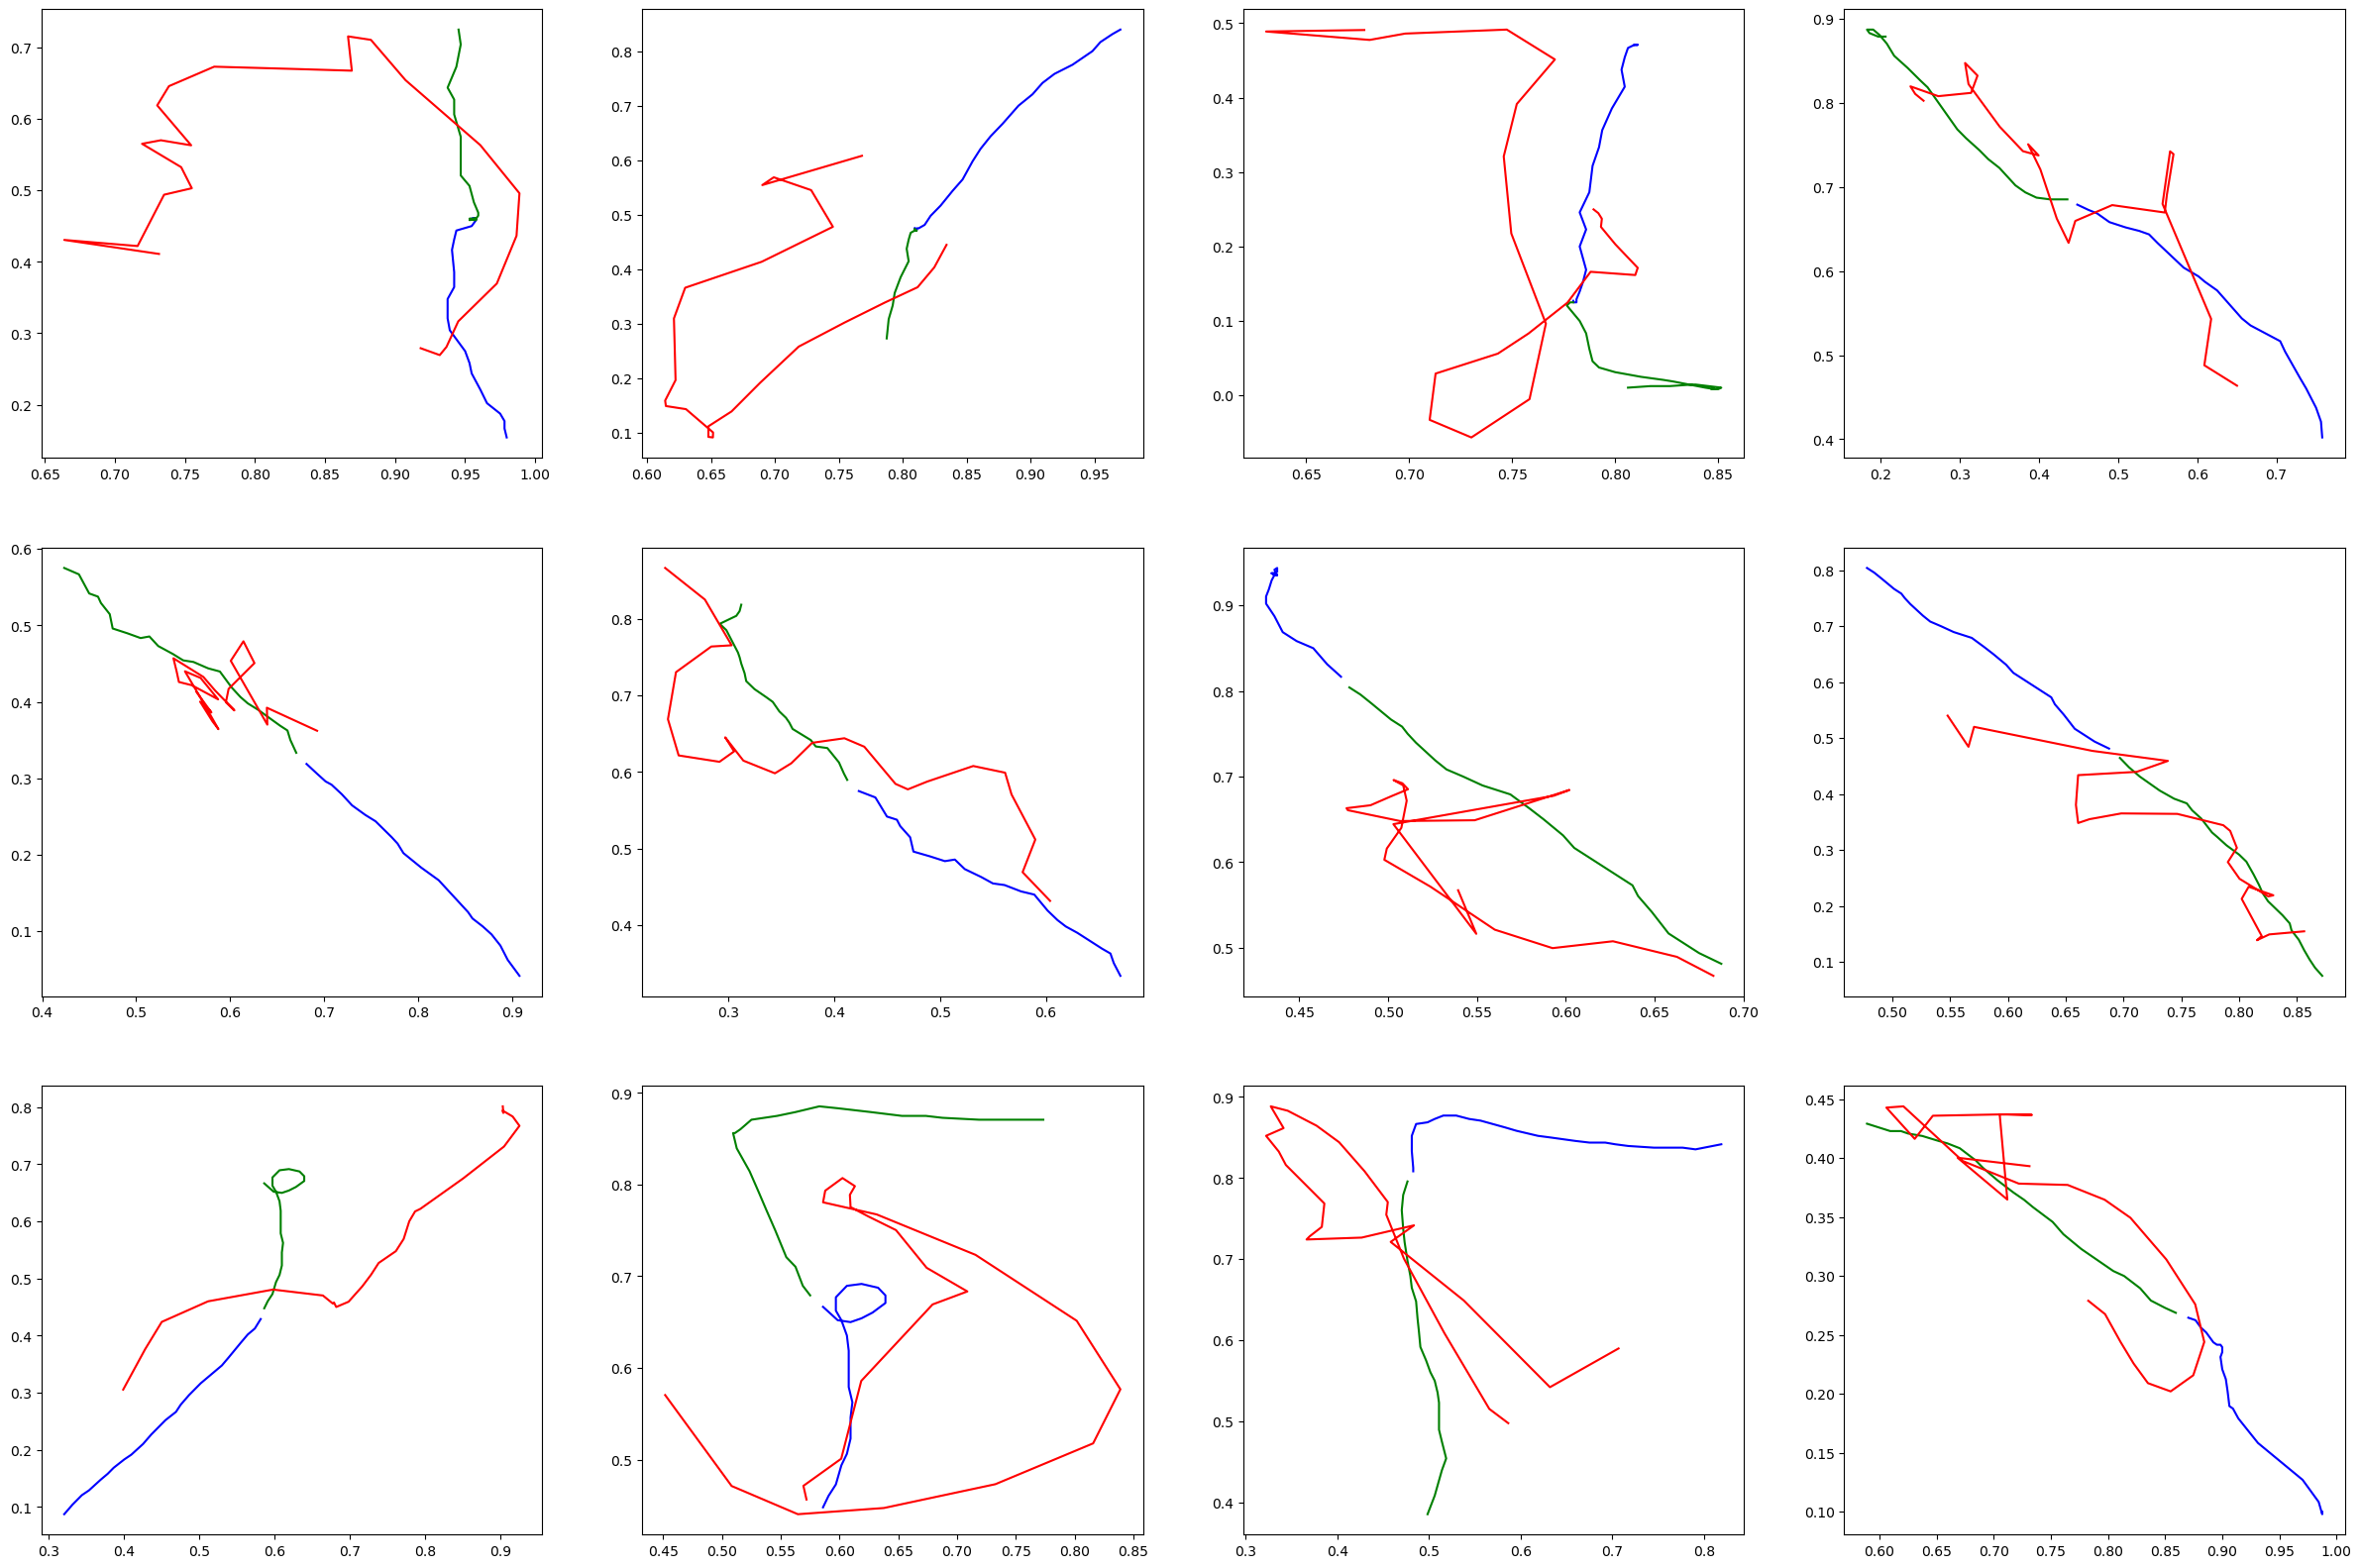

In [9]:
pred = model.predict(test_X)

fig = plt.figure(figsize=[30, 20])
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1)
    ax.plot(test_X[i*5,:,0], test_X[i*5,:,1], 'b')
    ax.plot(test_Y[i*5,:,0], test_Y[i*5,:,1], 'g')
    ax.plot(pred[i*5,:,0], pred[i*5,:,1], 'r')

Our results are weird. A lot of these look very odd. What's going on?

Part of the issue is that way that we make our prediction. We don't actually analyse the whole sequence, then predict the next sequence, rather we predict it as we go. The stacked LSTMs overcome this somewhat, but we can see that in a lot of cases we still get some pretty poor predictions.

## Approach 2: Bi-Directional LSTMs

We'll use a bi-directional LSTM now. This will parse the input both in the forwards and backwards directions, and thus do a better job of considering the entire input when generating the output. This will greatly help our model to make sense of things. Out network is otherwise much the same as it was last time.

In [10]:
pi_input = Input(shape = (25, 2), name = 'pedestrian_of_interest')
# encoder, now bi-directional, so will parse the sequence forwards and backwards
encoder_outputs = Bidirectional(LSTM(hidden_dim, return_sequences=True, return_state=False, 
                                     unroll=False, name='pi_encoder1'), merge_mode='sum')(pi_input)
# decoder, same as last time
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=False, 
                    unroll=False, name='pi_decoder1')(encoder_outputs)
# output layer, going from 300 -> 2 dimensions for each timestep
output = TimeDistributed(Dense(2), name='output_trajectory')(decoder_lstm)

model = Model(pi_input, output)

model.compile('adam', 'mse', metrics=['accuracy'], jit_compile=False)
model.summary()
# NOTE: at present, using tf 2.15.0 and keras 3.0.2, plot_model doesn't work with show_shape=True here. 
# I think it's to do with the TimeDistributed layer not being rendered properly - or more specifically the 
# shapes for that not being parsed properly. If you set show_shapes = False, it works. I think that showing
# the shapes is quite useful, so I've just turned it off.
#plot_model(model, show_shapes=True, dpi=60)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ pedestrian_of_interest          │ (None, 25, 2)             │          0 │
│ (InputLayer)                    │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bidirectional (Bidirectional)   │ (None, 25, 300)           │    727,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ pi_decoder1 (LSTM)              │ (None, 25, 300)           │    721,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ output_trajectory               │ (None, 25, 2)             │        602 │
│ (TimeDistributed)               │                           │            │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,449,002 (5.53 MB)

 Trainable params: 1,449,002 (5.53 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.fit(train_X, train_Y,
          batch_size=128,
          epochs=20,
          validation_data=(test_X, test_Y))

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.6636 - loss: 0.0936 - val_accuracy: 0.8375 - val_loss: 0.0401
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 276ms/step - accuracy: 0.8200 - loss: 0.0342 - val_accuracy: 0.8690 - val_loss: 0.0351
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 275ms/step - accuracy: 0.8713 - loss: 0.0235 - val_accuracy: 0.9088 - val_loss: 0.0290
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 277ms/step - accuracy: 0.8686 - loss: 0.0225 - val_accuracy: 0.9218 - val_loss: 0.0204
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 277ms/step - accuracy: 0.8887 - loss: 0.0177 - val_accuracy: 0.9212 - val_loss: 0.0147
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.8890 - loss: 0.0163 - val_accuracy: 0.9094 - val_loss: 0.0169
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - accuracy: 0.8999 - loss: 0.0149 - val_accuracy: 0.9220 - val_loss: 0.0133
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.9025 - loss: 0.0142 - val_accu

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


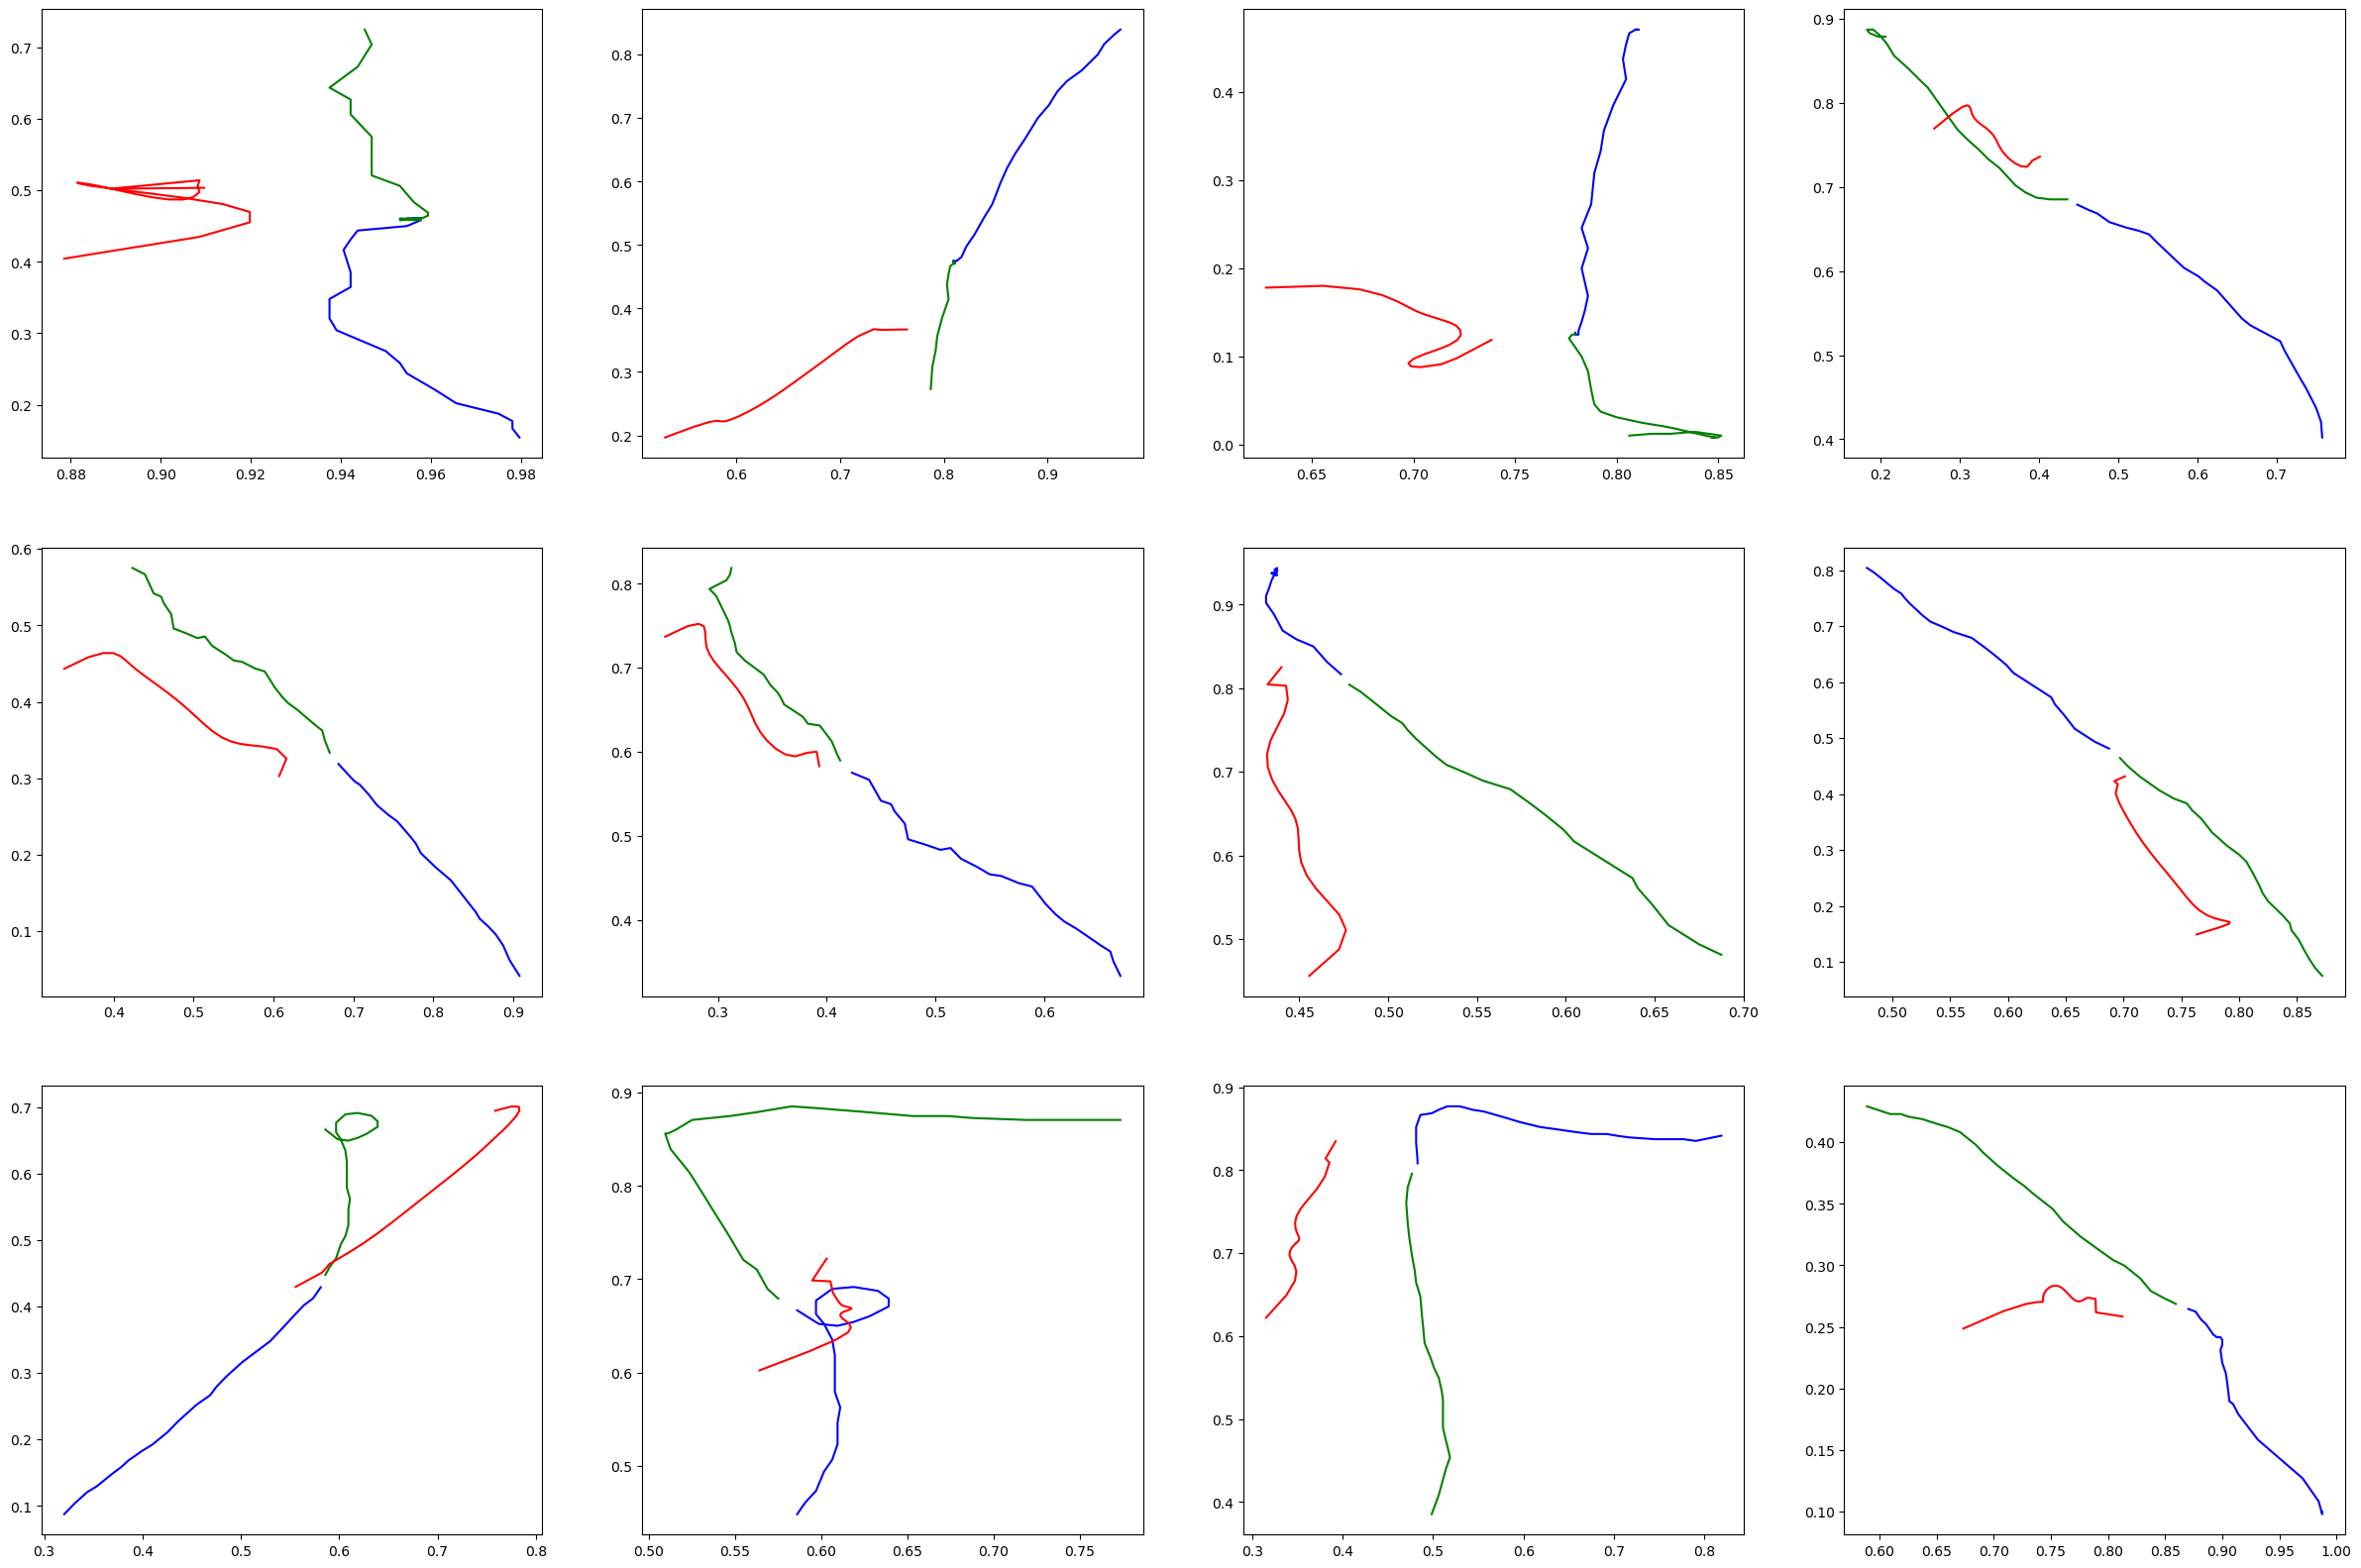

In [12]:
pred = model.predict(test_X)

fig = plt.figure(figsize=[30, 20])
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1)
    ax.plot(test_X[i*5,:,0], test_X[i*5,:,1], 'b')
    ax.plot(test_Y[i*5,:,0], test_Y[i*5,:,1], 'g')
    ax.plot(pred[i*5,:,0], pred[i*5,:,1], 'r')

Looking at the results, this looks much better, and much more like what we expect. We have a couple of weird ones in here, but these are typically the result of odd looking inputs, suggesting that there's more than just a poor performing model at play. By considering the entire sequence at once before making our prediction, we're able to do a much better job.

### Approach 1.5

I've tacked this at the end, as it's really an extra little bit you could ignore. We can actually go slightly further with these sort of models, and give the LSTM decoder some extra information to help with it's job. We can do this by getting the state back from the encoder LSTM, and using that to initialise the decoder LSTM. This is shown here.

Here I'm doing this for the uni-directional LSTM for two reasons:
* The difference is way more dramatic
* The version of keras I'm using (3.0.2) breaks when this is used with the Bidirectional wrapper (though that will no doubt get fixed in the future).

We see that with this approach, we get performance pretty similar to our bi-directional network - but without the added overhead of that. The reason for this is that by passing the state out of the encoder LSTM and into the decoder to intitialise it, we're simply finding another way to give that decoder more information, so helping solve that problem.

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ pedestrian_of_inte… │ (None, 25, 2)     │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ pi_encoder1 (LSTM)  │ [(None, 25, 300), │ 363,600 │ pedestrian_of_inter… │
│                     │ (None, 300),      │         │                      │
│                     │ (None, 300)]      │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ pi_decoder1 (LSTM)  │ (None, 25, 300)   │ 721,200 │ pi_encoder1[0][0],   │
│                     │                   │         │ pi_encoder1[0][1],   │
│                     │                   │         │ pi_encoder1[0][2]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ output_trajectory   │ (None, 25, 2)     │     602 │ pi_decoder1[0][0]    │
│ (TimeDistributed)   │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 1,085,402 (4.14 MB)

 Trainable params: 1,085,402 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 205ms/step - accuracy: 0.6769 - loss: 0.0843 - val_accuracy: 0.9198 - val_loss: 0.0259
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.8838 - loss: 0.0263 - val_accuracy: 0.9301 - val_loss: 0.0204
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.8978 - loss: 0.0178 - val_accuracy: 0.9248 - val_loss: 0.0120
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.9112 - loss: 0.0141 - val_accuracy: 0.9332 - val_loss: 0.0095
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.9161 - loss: 0.0124 - val_accuracy: 0.9445 - val_loss: 0.0098
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.9181 - loss: 0.0106 - val_accuracy: 0.9418 - val_loss: 0.0107
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.9240 - loss: 0.0101 - val_accuracy: 0.9177 - val_loss: 0.0128
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.9208 - loss: 0.0106 - val_accu

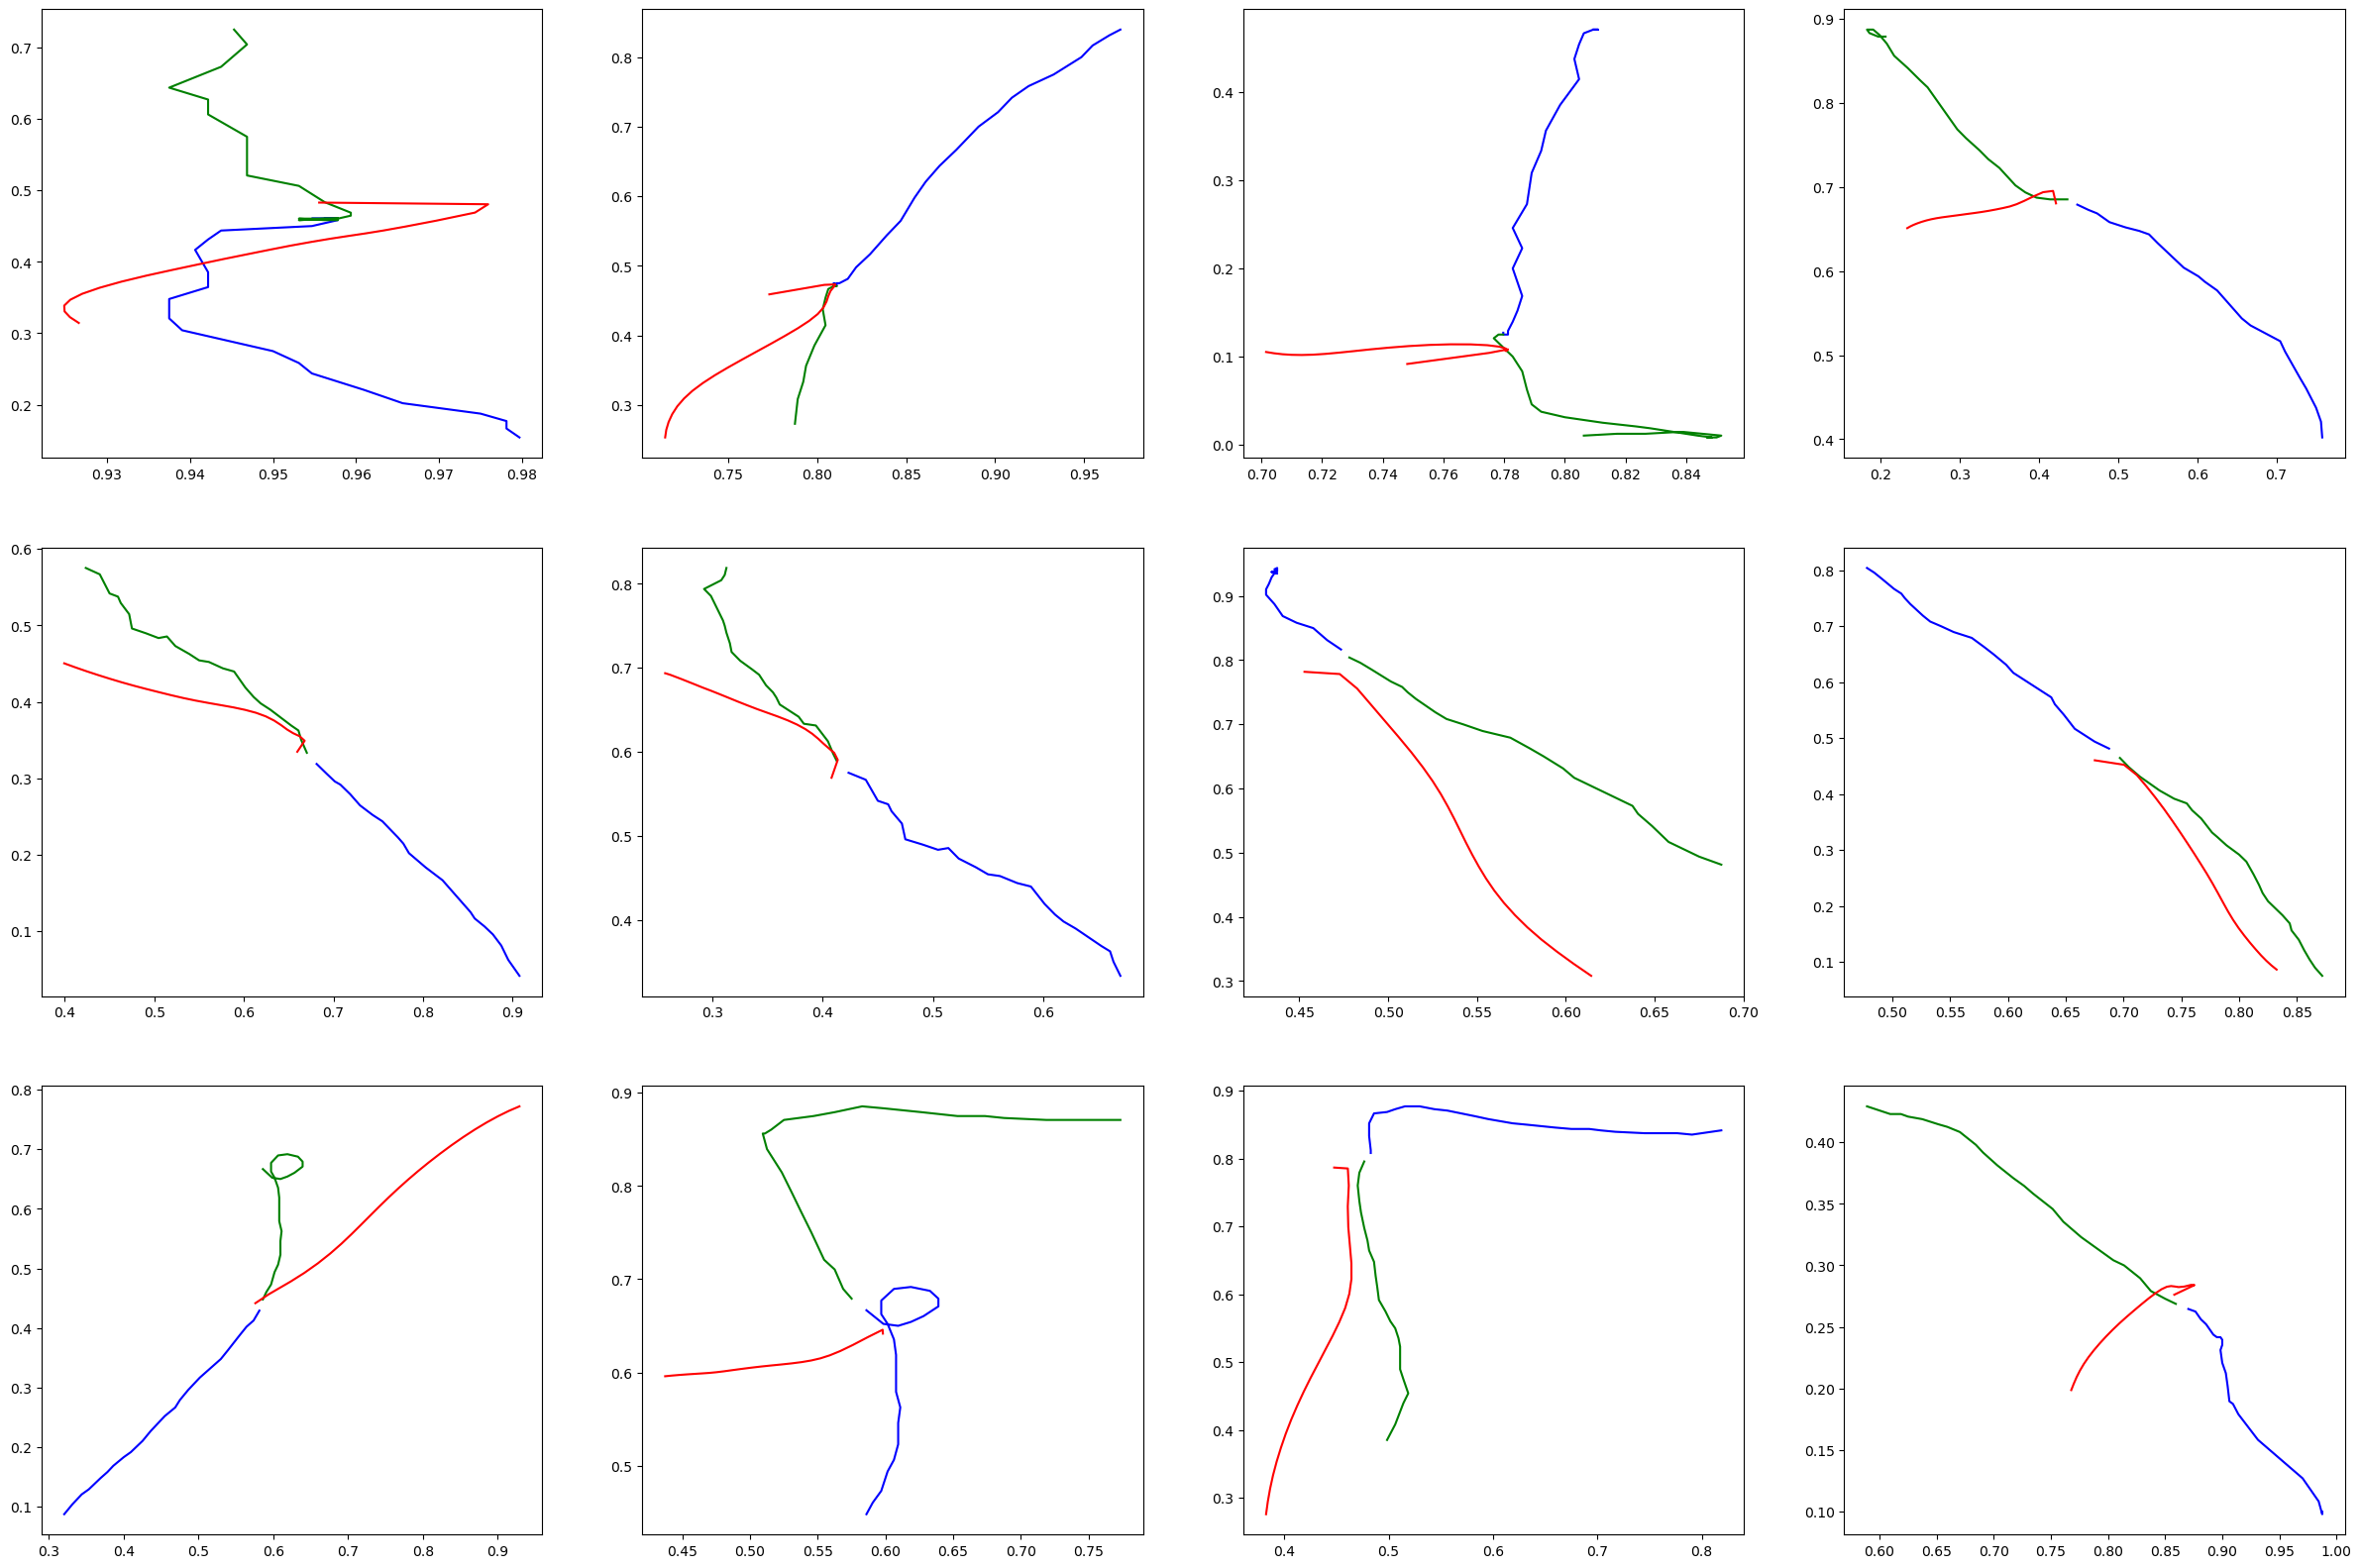

In [13]:
hidden_dim = 300
pi_input = Input(shape = (25, 2), name = 'pedestrian_of_interest')

# encoder - return_state is now set to True. As such we get two extra outputs from our LSTM
encoder_outputs, e1_h, e1_c = LSTM(hidden_dim, return_sequences=True, return_state=True, 
                                   unroll=False, name='pi_encoder1')(pi_input)
# we'll pack these states into a single variable
e1_states = [e1_h, e1_c]
# and then pass these as the initial states to the decoder LSTM
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=False, 
                    unroll=False, name='pi_decoder1')(encoder_outputs, initial_state=e1_states)
# after that everything follows the same pattern as before
output = TimeDistributed(Dense(2), name='output_trajectory')(decoder_lstm)

model = Model(pi_input, output)

model.compile('adam', 'mse', metrics=['accuracy'], jit_compile=False)
model.summary()

model.fit(train_X, train_Y,
          batch_size=128,
          epochs=20,
          validation_data=(test_X, test_Y))

pred = model.predict(test_X)

fig = plt.figure(figsize=[30, 20])
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1)
    ax.plot(test_X[i*5,:,0], test_X[i*5,:,1], 'b')
    ax.plot(test_Y[i*5,:,0], test_Y[i*5,:,1], 'g')
    ax.plot(pred[i*5,:,0], pred[i*5,:,1], 'r')

## Final Thoughts

We've looked at predicting sequences in this example. We can do this with LSTMs, and all we need to do is ask them to output a sequence. There some other things to consider though. By default, the LSTMs will not use the entire sequence to make the entire prediction, rather it will go through the sequence and predict one state/output at a time. We can somewhat overcome this using stacked LSTMs, but it's still not great. We get far better performance using a bi-directional LSTM which looks at the sequence in the forwards and backwards directions, and uses this to make the prediction.

There are some other things of note:
* Our loss function is limited here, in that we just do MSE over the whole trajectory. This actually makes it more important for the model to be correct at the end of the trajectory rather than the start, so we see disconnects between the previous and predicted paths.
* We haven't normalised our data as much as we could. We could for eaxmple, have centred every example, which would likely help learning
* We have not considered the embedding size we are using, or if it is optimal, rather we've just picked a number. This could likely be improved.